In [1]:
%load_ext autoreload
%autoreload 2
import datahelper

import numpy as np
import tensorflow as tf
from tensorflow import keras as kr
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import cv2
import matplotlib.pyplot as plt
from IPython.display import Video

np.random.seed(4212)
device_list = tf.config.get_visible_devices()
tf.config.set_visible_devices(device_list[::2])

In [2]:
DATA_PATH = "/home/mattr/Desktop/udacity/CarND-Behavioral-Cloning-P3/training/data/"
DRIVING_FOLDERS = {'easy': 'drivingData', 'hard': 'drivingDataHard', 'john': 'johnsDrivingData'}

# Data Pre-Processing

## Step 1: Load data and clean csv
- I recorded some data on my laptop but I'm training the model on my own dl server so I have to change the path names.
- Next I'm going to split the data into test and training sets
## Step 2: Data Exploration!!
- I will load some images from the training set and decide on image processing steps
- Find distributions of steering angle, throttle, break, and speed
## Step 3: Make a data pipeline
- Once I have determined the best pre-processing steps I will implement a pipeline to pre-process all the data


## Step 1

In [3]:
easy_driving_df = datahelper.process.preprocessing.import_driving_log(DATA_PATH+DRIVING_FOLDERS['easy']+'/driving_log.csv', DATA_PATH)
hard_driving_df = datahelper.process.preprocessing.import_driving_log(DATA_PATH+DRIVING_FOLDERS['hard']+'/driving_log.csv', DATA_PATH)
john_driving_df = datahelper.process.preprocessing.import_driving_log(DATA_PATH+DRIVING_FOLDERS['john']+'/driving_log.csv', DATA_PATH)
easy_driving_df.head()

,center_img,left_img,right_img,steering_angle,throttle,brake,speed
0,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,0.000000,0.0,0.0,25.32430
1,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,0.000000,0.0,0.0,25.17072
2,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,0.000000,0.0,0.0,24.96740
3,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,0.000000,0.0,0.0,24.81597
4,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,-0.112782,0.0,0.0,24.66253


In [4]:
easy_driving_df['center_img'][0]

'/home/mattr/Desktop/udacity/CarND-Behavioral-Cloning-P3/training/data/drivingData/IMG/center_2021_09_29_12_10_46_429.jpg'

In [5]:
easy_records = [datahelper.datasets.DrivingRecord(record) for record in datahelper.process.preprocessing.find_records(easy_driving_df)]
hard_records = [datahelper.datasets.DrivingRecord(record) for record in datahelper.process.preprocessing.find_records(hard_driving_df)]
john_records = [datahelper.datasets.DrivingRecord(record) for record in datahelper.process.preprocessing.find_records(john_driving_df)]

In [6]:
print(f"Number of easy records: {len(easy_records)}\nNumber of hard records: {len(hard_records)}\nNumber of john records: {len(john_records)}")

Number of easy records: 4
Number of hard records: 5
Number of john records: 9


In [7]:
s = 0
for record in easy_records:
    s += len(record)
print("Average length of easy_records", s/4)
s = 0
for record in hard_records:
    s += len(record)
print("Average length of hard_records", s/5)
s = 0
for record in john_records:
    s += len(record)
print("Average length of john_records", round(s/9, 1))

Average length of easy_records 981.5
Average length of hard_records 1734.2
Average length of john_records 812.4


In [8]:
for index, record in enumerate(easy_records):
    record_length = len(record)
    ave_speed = sum([record.get_attribute(i, 'speed') for i in range(record_length)])
    ave_speed /= record_length
    print(f"Average speed of easy record {index} =", ave_speed)

Average speed of easy record 0 = 29.93008383971288
Average speed of easy record 1 = 15.111851774612253
Average speed of easy record 2 = 23.34869946835444
Average speed of easy record 3 = 15.327890382206723


In [9]:
for index, record in enumerate(hard_records):
    record_length = len(record)
    ave_speed = sum([record.get_attribute(i, 'speed') for i in range(record_length)])
    ave_speed /= record_length
    print(f"Average speed of hard record {index} =", ave_speed)

Average speed of hard record 0 = 18.15653915810563
Average speed of hard record 1 = 21.325574233684627
Average speed of hard record 2 = 12.01282012592593
Average speed of hard record 3 = 11.536492432081914
Average speed of hard record 4 = 13.686280197900263


In [10]:
for index, record in enumerate(john_records):
    record_length = len(record)
    ave_speed = sum([record.get_attribute(i, 'speed') for i in range(record_length)])
    ave_speed /= record_length
    print(f"Average speed of john record {index} =", ave_speed)

Average speed of john record 0 = 18.46285795635445
Average speed of john record 1 = 25.274414103228565
Average speed of john record 2 = 18.534745673547665
Average speed of john record 3 = 29.81729226015545
Average speed of john record 4 = 12.926317482499453
Average speed of john record 5 = 22.476285131699218
Average speed of john record 6 = 24.99603134644568
Average speed of john record 7 = 25.182528864181908
Average speed of john record 8 = 23.072508095906592


In [11]:
from tensorflow.image import extract_patches

In [12]:
patches = extract_patches(
    images = easy_records[0][0][:1],
    sizes = [1, 20, 40, 1],
    strides = [1, 20, 40, 1],
    rates = [1, 1, 1, 1],
    padding = "VALID" )

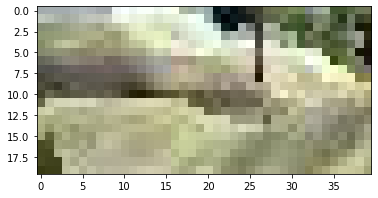

In [13]:
import matplotlib.pyplot as plt
plt.imshow(patches[0, 2, 2, :].numpy().reshape(20, 40, 9)[:, :, 3:6])

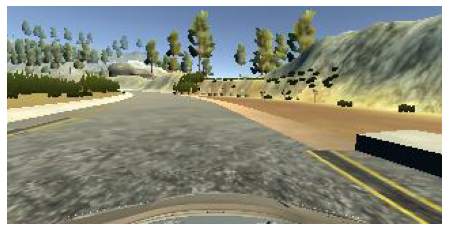

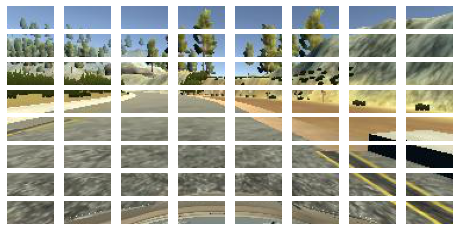

In [14]:
plt.figure(figsize=(8, 4))
plt.imshow(easy_records[0][0][0][:, :, 3:6])
plt.axis("off")

plt.figure(figsize=(8, 4))
for i in range(8):
    for j in range(8):
        ax = plt.subplot(8, 8, i*8+j+1)
        plt.imshow(patches[0, i, j, :].numpy().reshape(20, 40, 9)[:, :, 3:6])
        plt.axis("off")

In [15]:
easy_patches_300 = extract_patches(
    images = easy_records[0][:600][0],
    sizes = [1, 20, 40, 1],
    strides = [1, 20, 40, 1],
    rates = [1, 1, 1, 1],
    padding = "VALID" )

In [16]:
image_patches = tf.reshape(easy_patches_300, shape=[-1, 20, 40, 9])

In [17]:
from datahelper.models.gan import EncoderModel, DecoderModel, GeneratorModel, AdversarialModel, GAN

In [42]:
my_encoder_model = EncoderModel((20, 40), 9, 128)
my_decoder_model = DecoderModel()
my_generator = GeneratorModel(my_encoder_model, my_decoder_model)
my_adversary = AdversarialModel()
my_gan = GAN(my_generator, my_adversary)


In [43]:
my_encoder_model.build(input_shape=(None, 20, 40, 9))


In [44]:
my_gan.compile(gen_optimizer=tf.keras.optimizers.Adamax(5e-5), adv_optimizer=tf.keras.optimizers.Adamax(1e-5))

In [48]:
history = my_gan.fit(image_patches, tf.ones(shape=[image_patches.shape[0], 1]), batch_size=128, epochs=1000)

Epoch 1/1000
300/300 [==============================] - 3s 11ms/step - gen_loss: 5.3136 - adv_loss: 0.7663 - img_loss: 0.1317
Epoch 2/1000
300/300 [==============================] - 3s 11ms/step - gen_loss: 5.3128 - adv_loss: 0.7664 - img_loss: 0.1317
Epoch 3/1000
300/300 [==============================] - 3s 11ms/step - gen_loss: 5.3120 - adv_loss: 0.7666 - img_loss: 0.1316
Epoch 4/1000
300/300 [==============================] - 3s 11ms/step - gen_loss: 5.3111 - adv_loss: 0.7667 - img_loss: 0.1316
Epoch 5/1000
300/300 [==============================] - 3s 11ms/step - gen_loss: 5.3102 - adv_loss: 0.7668 - img_loss: 0.1316
Epoch 6/1000
300/300 [==============================] - 3s 11ms/step - gen_loss: 5.3094 - adv_loss: 0.7670 - img_loss: 0.1316
Epoch 7/1000
300/300 [==============================] - 3s 11ms/step - gen_loss: 5.3085 - adv_loss: 0.7671 - img_loss: 0.1316
Epoch 8/1000
300/300 [==============================] - 3s 11ms/step - gen_loss: 5.3077 - adv_loss: 0.7672 - img_loss:

In [39]:
def plot_samples(images):
    gen_images, _ = my_generator(images)
    for gen_image, image in zip(gen_images, images):
        ax = plt.subplot(2, 1, 1)
        plt.imshow(image[:,:, 3:6])
        
        ax = plt.subplot(2, 1, 2)
        plt.imshow(gen_image[:, :, 3:6])
        plt.show()

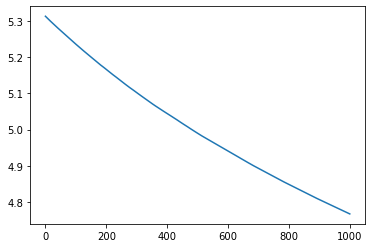

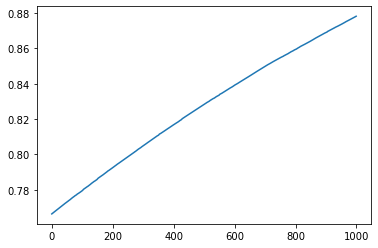

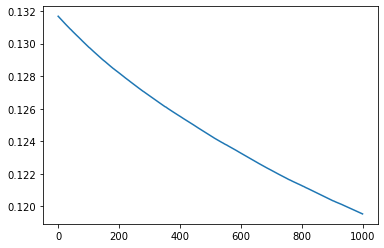

In [49]:
plt.plot(history.history['gen_loss'])
plt.show()
plt.plot(history.history['adv_loss'])
plt.show()
plt.plot(history.history['img_loss'])

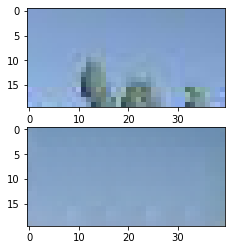

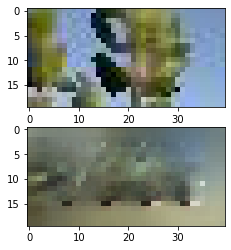

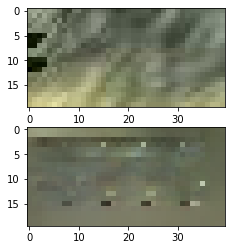

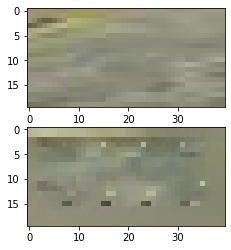

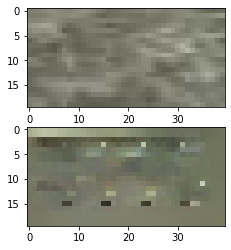

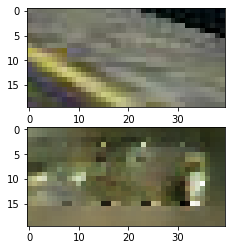

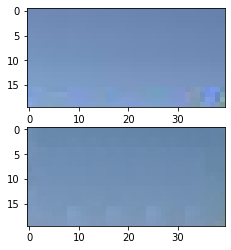

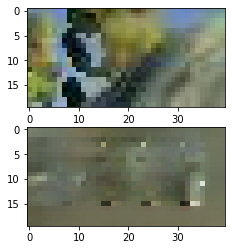

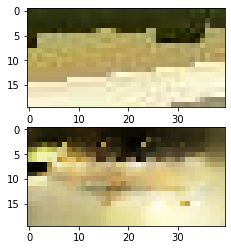

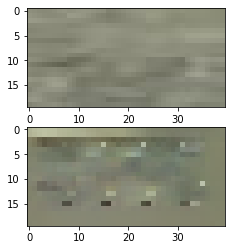

In [50]:
plot_samples(image_patches[0:100:11])

In [97]:
my_encoder_model.save("./encoderv7")
my_decoder_model.save("./decoderv7")
my_generator.save("./generatorv7")
my_adversary.save("./adversaryv7")
#my_gan.save("./gan")

INFO:tensorflow:Assets written to: ./encoderv7/assets
INFO:tensorflow:Assets written to: ./decoderv7/assets
INFO:tensorflow:Assets written to: ./generatorv7/assets
INFO:tensorflow:Assets written to: ./adversaryv7/assets
